In [1]:
import os, sys
import h5py
import numpy as np
from numpy import genfromtxt
import nibabel as nb
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from nibabel.freesurfer.io import read_geometry
from nilearn.plotting.surf_plotting import load_surf_data
from nilearn.plotting.surf_plotting import load_surf_mesh
from brainspace.gradient import GradientMaps
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from brainspace.datasets import load_conte69
from brainspace.null_models import SpinPermutations
import hcp_utils
# in house modules from the repo:
import plot_funcs                                
from plot_funcs import make_spider_rvalues           
sys.path.append('../vis')                           
from vis import surfaces

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


### read-in cortical-cortical functional connectivity gradients

In [2]:
fgradscortex = '../data/tout_group/Hmean709isocortex_gradients.h5'

f = h5py.File(fgradscortex, 'r')

G1_fc_isocortex = np.array(f['gradients_'])[:,0]
G2_fc_isocortex = np.array(f['gradients_'])[:,1]
G3_fc_isocortex = np.array(f['gradients_'])[:,2]

### in-house plotting for fsaverage

In [3]:
# load surfaces
surf_lh, surf_rh = load_conte69()

# load labeling file
labeling_file = '../data/tout_group/glasser.csv' 
labeling = genfromtxt(labeling_file)

mask = labeling != 0 # this takes the mask of the left hem only..

mymask = np.ones((64984,)).astype('bool')
mymask[np.where(mask == False)[0]] = False
mymask[np.where(mask == False)[0] + 32492] = False


In [4]:
Fs_Mesh_L = nb.load('./vis/fsaverage/S1200.L.pial_MSMAll.32k_fs_LR.surf.gii').agg_data()
Fs_Mesh_R = nb.load('./vis/fsaverage/S1200.R.pial_MSMAll.32k_fs_LR.surf.gii').agg_data()

SURF_MESH = {}
SURF_MESH['coords'] = np.concatenate((Fs_Mesh_L[0], Fs_Mesh_R[0]))
SURF_MESH['tri']    = np.concatenate((Fs_Mesh_L[1], Fs_Mesh_R[1]))

A = hcp_utils.load_surfaces()

maskindex = []
for i in range(0, 64984):
    if mymask[i] == True:
        maskindex.append(i)
maskindex = np.array(maskindex)
maskindex

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


array([    0,     1,     2, ..., 64981, 64982, 64983])

### label macroscale gradients 

In [5]:
XG1_labeled = map_to_labels(G1_fc_isocortex, labeling, mask = mymask)
XG1_labeled[np.where(mymask == False)] = np.nan

XG2_labeled = map_to_labels(G2_fc_isocortex, labeling, mask = mymask)
XG2_labeled[np.where(mymask == False)] = np.nan

XG3_labeled = map_to_labels(G3_fc_isocortex, labeling, mask = mymask)
XG3_labeled[np.where(mymask == False)] = np.nan


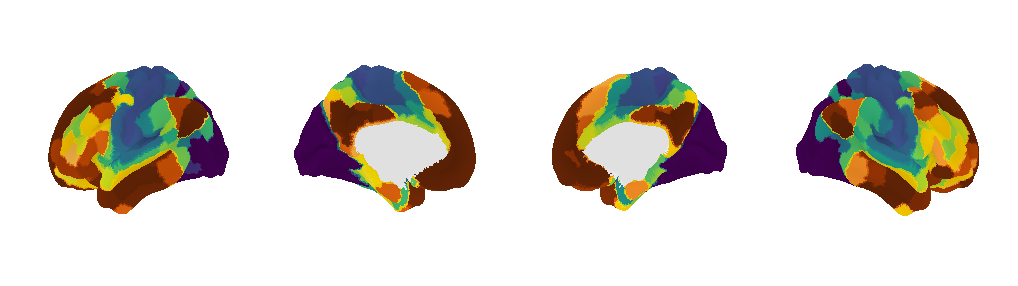

In [6]:
fig01 = surfaces.plot_surfstat(SURF_MESH, A['sulc'],
                               XG1_labeled, alpha=1, cmap=plot_funcs.margu_map(), 
                               vmin=-0.9, vmax=1.3, mask=maskindex)


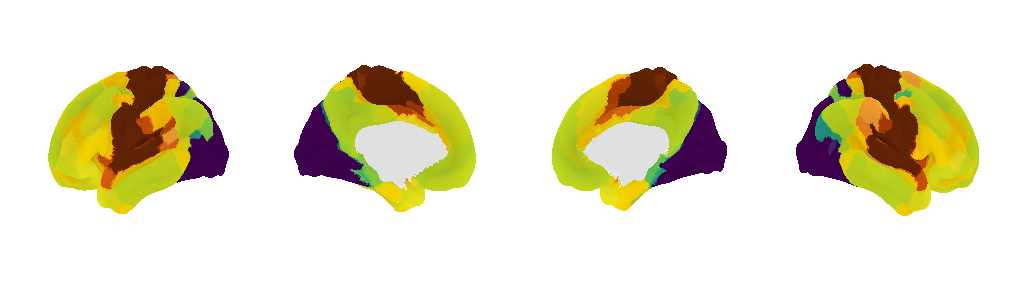

In [7]:
fig02 = surfaces.plot_surfstat(SURF_MESH, A['sulc'],
                               XG2_labeled, alpha=1, cmap=plot_funcs.margu_map(), 
                               vmin=-1, vmax=1, mask=maskindex)


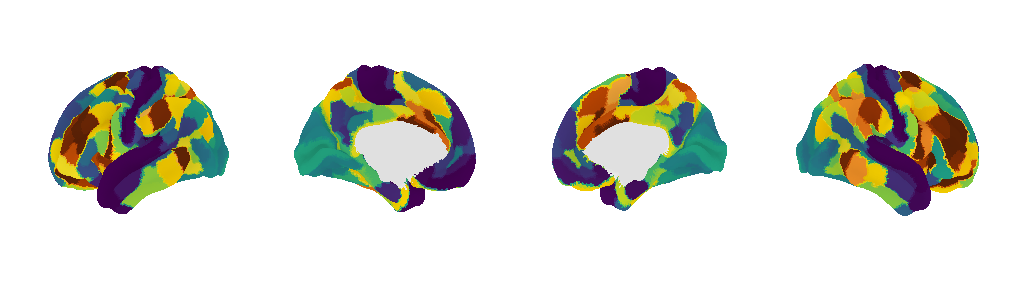

In [8]:
fig03 = surfaces.plot_surfstat(SURF_MESH, A['sulc'],
                               XG3_labeled, alpha=1, cmap=plot_funcs.margu_map(), 
                               vmin=-0.7, vmax=1.1, mask=maskindex)

### re-compute the G1 (fus) and G2 (fus) projections on cortical fc

In [9]:
# load surfaces
surf_lh, surf_rh = load_conte69()

# load labeling file
labeling_file = '../data/tout_group/glasser.csv' 
labeling = genfromtxt(labeling_file)

mask = labeling != 0 # this takes the mask of the left hem only..

mymask = np.ones((64984,)).astype('bool')
mymask[np.where(mask == False)[0]] = False
mymask[np.where(mask == False)[0] + 32492] = False

In [10]:
# correlations between G2 (fused) of subfields and functional connectivity to the iscocortex

gdir = outdir = '../data/tout_group/'

fcfile = os.path.join(gdir, 'Hmean709_FC_left.h5')
f = h5py.File(fcfile, 'r')
fcon_LSUB = np.array(f['data'][0:1024,:])
fcon_LCA  = np.array(f['data'][1024:1024+2048,:])
fcon_LDG  = np.array(f['data'][1024+2048:1024+1024+2048,:])

ddir = '../data/tout_group/'

# read-in primary and seconardy fusion gradients (G1 & G2) 
h  = h5py.File(os.path.join(ddir, 'Hmean709fusedGradients_left.h5'), 'r');
data = np.array(h['data'])

G1_fus_LSUB = data[0:1024,0]
G1_fus_LCA  = data[1024:1024+2048,0]
G1_fus_LDG  = data[1024+2048:1024+2048+1024,0]

G2_fus_LSUB = data[0:1024,1]
G2_fus_LCA  = data[1024:1024+2048,1]
G2_fus_LDG  = data[1024+2048:1024+2048+1024,1]



In [11]:
# correlations between G1 (fused) of subfields and functional connectivity to the iscocortex

r1_LSUB = np.zeros((360,))
r1_LCA  = np.zeros((360,))
r1_LDG = np.zeros((360,))

for k in range(0, 360):
    r1_LSUB[k] = np.corrcoef(fcon_LSUB.T[k,:], G1_fus_LSUB)[-1:,:-1][0,0]
    r1_LCA[k]  = np.corrcoef(fcon_LCA.T[k,:], G1_fus_LCA)[-1:,:-1][0,0]
    r1_LDG[k]  = np.corrcoef(fcon_LDG.T[k,:], G1_fus_LDG)[-1:,:-1][0,0]

# correlations between G2 (fused) of subfields and functional connectivity to the iscocortex

r2_LSUB = np.zeros((360,))
r2_LCA  = np.zeros((360,))
r2_LDG = np.zeros((360,))

for k in range(0, 360):
    r2_LSUB[k] = np.corrcoef(fcon_LSUB.T[k,:], G2_fus_LSUB)[-1:,:-1][0,0]
    r2_LCA[k]  = np.corrcoef(fcon_LCA.T[k,:], G2_fus_LCA)[-1:,:-1][0,0]
    r2_LDG[k]  = np.corrcoef(fcon_LDG.T[k,:], G2_fus_LDG)[-1:,:-1][0,0]
    


In [12]:
# map r-values to the isocortex
r1_LSUB_labeled = map_to_labels(r1_LSUB, labeling, mask=mymask) 
r1_LSUB_labeled[np.where(mymask == False)] = np.nan

r1_LCA_labeled = map_to_labels(r1_LCA, labeling, mask=mymask) 
r1_LCA_labeled[np.where(mymask == False)] = np.nan


r1_LDG_labeled = map_to_labels(r1_LDG, labeling, mask=mymask) 
r1_LDG_labeled[np.where(mymask == False)] = np.nan


r2_LSUB_labeled = map_to_labels(r2_LSUB, labeling, mask=mymask) 
r2_LSUB_labeled[np.where(mymask == False)] = np.nan

r2_LCA_labeled = map_to_labels(r2_LCA, labeling, mask=mymask) 
r2_LCA_labeled[np.where(mymask == False)] = np.nan


r2_LDG_labeled = map_to_labels(r2_LDG, labeling, mask=mymask) 
r2_LDG_labeled[np.where(mymask == False)] = np.nan

## association between G1(fus)-projection and G3 (cortex)

Pearson correlation:  (-0.6715870271613189, 0.0)


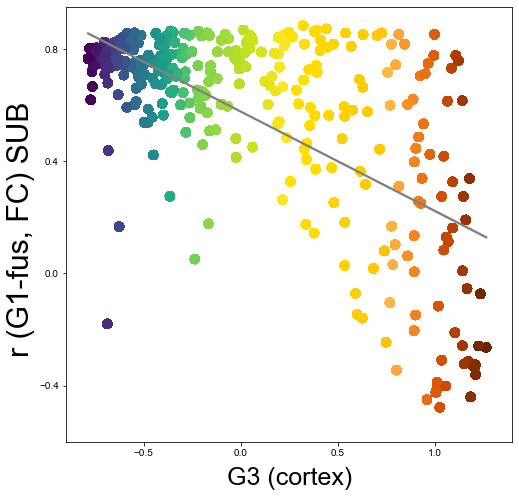

In [13]:
figure = plt.figure(figsize=(8,8), facecolor='w')

ax     = figure.gca()
ax.patch.set_facecolor('white')

xLabel = ax.set_xlabel('\nG3 (cortex)', linespacing=0, fontsize=25)
yLabel = ax.set_ylabel('r (G1-fus, FC) SUB ', linespacing=3.1, fontsize=30)

sns.regplot(x=XG3_labeled[~np.isnan(r1_LSUB_labeled)],
            y=r1_LSUB_labeled[~np.isnan(r1_LSUB_labeled)], color='gray', scatter=False)

ax.scatter(XG3_labeled[~np.isnan(r1_LSUB_labeled)], 
           r1_LSUB_labeled[~np.isnan(r1_LSUB_labeled)],
           c = XG3_labeled[~np.isnan(r1_LSUB_labeled)], 
           cmap= plot_funcs.margu_map(),
           s = 100,
           linewidth = 0,
           marker = 'o', )

ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xlim([-0.9, 1.4])
ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
ax.set_ylim([-0.6, 0.95])

sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_style("ticks")

print("Pearson correlation: ", pearsonr(r1_LSUB_labeled[~np.isnan(r1_LSUB_labeled)],
                                        XG3_labeled[~np.isnan(r1_LSUB_labeled)]))


Pearson correlation:  (0.005641389911866468, 0.16918866358354806)


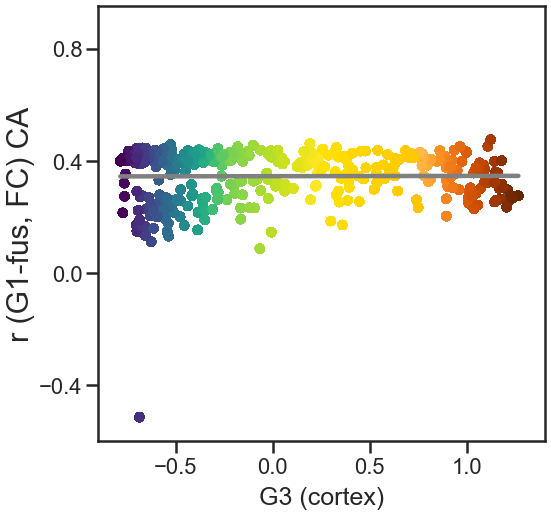

In [14]:
figure = plt.figure(figsize=(8,8), facecolor='w')

ax     = figure.gca()
ax.patch.set_facecolor('white')

xLabel = ax.set_xlabel('\nG3 (cortex)', linespacing=0, fontsize=25)
yLabel = ax.set_ylabel('r (G1-fus, FC) CA', linespacing=3.1, fontsize=30)

sns.regplot(x=XG3_labeled[~np.isnan(r1_LCA_labeled)],
            y=r1_LCA_labeled[~np.isnan(r1_LCA_labeled)], color='gray', scatter=False)

ax.scatter(XG3_labeled[~np.isnan(r1_LCA_labeled)], 
           r1_LCA_labeled[~np.isnan(r1_LCA_labeled)],
           c = XG3_labeled[~np.isnan(r1_LCA_labeled)], 
           cmap= plot_funcs.margu_map(),
           s = 100,
           linewidth = 0,
           marker = 'o', )

ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xlim([-0.9, 1.4])
ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
ax.set_ylim([-0.6, 0.95])

sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_style("ticks")

print("Pearson correlation: ", pearsonr(r1_LCA_labeled[~np.isnan(r1_LCA_labeled)],
                                        XG3_labeled[~np.isnan(r1_LCA_labeled)]))


Pearson correlation:  (0.5021774728964584, 0.0)


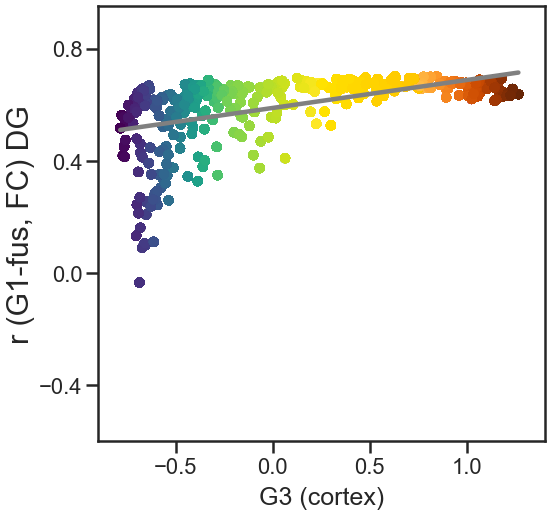

In [15]:
figure = plt.figure(figsize=(8,8), facecolor='w')

ax     = figure.gca()
ax.patch.set_facecolor('white')

xLabel = ax.set_xlabel('\nG3 (cortex)', linespacing=0, fontsize=25)
yLabel = ax.set_ylabel('r (G1-fus, FC) DG', linespacing=3.1, fontsize=30)

sns.regplot(x=XG3_labeled[~np.isnan(r1_LDG_labeled)],
            y=r1_LDG_labeled[~np.isnan(r1_LDG_labeled)], color='gray', scatter=False)

ax.scatter(XG3_labeled[~np.isnan(r1_LDG_labeled)], 
           r1_LDG_labeled[~np.isnan(r1_LDG_labeled)],
           c = XG3_labeled[~np.isnan(r1_LDG_labeled)], 
           cmap= plot_funcs.margu_map(),
           s = 100,
           linewidth = 0,
           marker = 'o', )

ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xlim([-0.9, 1.4])
ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
ax.set_ylim([-0.6, 0.95])

sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_style("ticks")

print("Pearson correlation: ", pearsonr(r1_LDG_labeled[~np.isnan(r1_LDG_labeled)],
                                        XG3_labeled[~np.isnan(r1_LDG_labeled)]))


## association between G2(fus)-projection and G3 (cortex)

Pearson correlation:  (0.8178705024144503, 0.0)


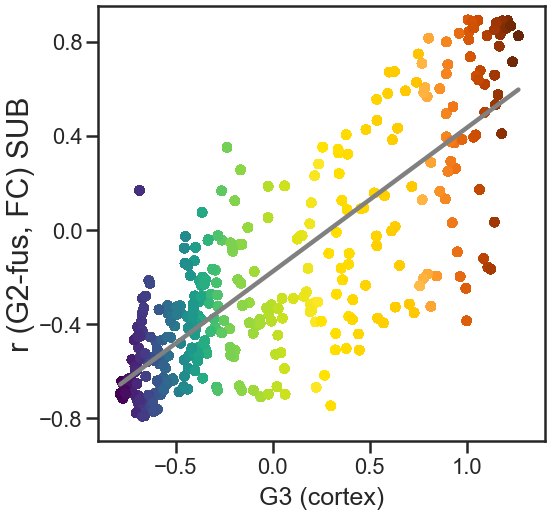

In [16]:
figure = plt.figure(figsize=(8,8), facecolor='w')

ax     = figure.gca()
ax.patch.set_facecolor('white')

xLabel = ax.set_xlabel('\nG3 (cortex)', linespacing=0, fontsize=25)
yLabel = ax.set_ylabel('r (G2-fus, FC) SUB', linespacing=3.1, fontsize=30)

sns.regplot(x=XG3_labeled[~np.isnan(r2_LSUB_labeled)],
            y=r2_LSUB_labeled[~np.isnan(r2_LSUB_labeled)], color='gray', scatter=False)

ax.scatter(XG3_labeled[~np.isnan(r2_LSUB_labeled)], 
           r2_LSUB_labeled[~np.isnan(r2_LSUB_labeled)],
           c = XG3_labeled[~np.isnan(r2_LSUB_labeled)], 
           cmap= plot_funcs.margu_map(),
           s = 100,
           linewidth = 0,
           marker = 'o', )

ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xlim([-0.9, 1.4])
ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
ax.set_ylim([-0.9, 0.95])

sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_style("ticks")

print("Pearson correlation: ", pearsonr(r2_LSUB_labeled[~np.isnan(r2_LSUB_labeled)],
                                        XG3_labeled[~np.isnan(r2_LSUB_labeled)]))


Pearson correlation:  (0.7917614962285551, 0.0)


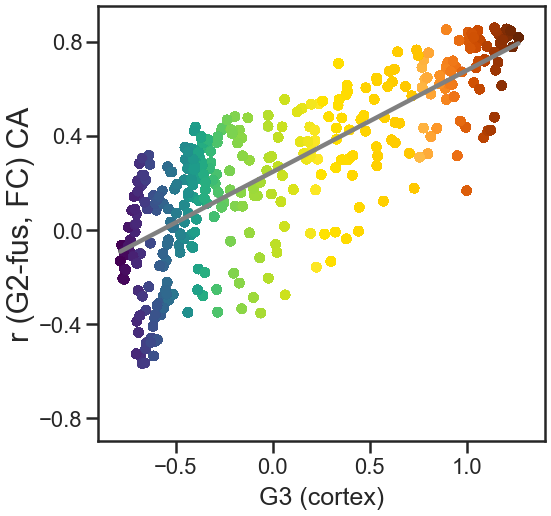

In [17]:
figure = plt.figure(figsize=(8,8), facecolor='w')

ax     = figure.gca()
ax.patch.set_facecolor('white')

xLabel = ax.set_xlabel('\nG3 (cortex)', linespacing=0, fontsize=25)
yLabel = ax.set_ylabel('r (G2-fus, FC) CA', linespacing=3.1, fontsize=30)

sns.regplot(x=XG3_labeled[~np.isnan(r2_LCA_labeled)],
            y=r2_LCA_labeled[~np.isnan(r2_LCA_labeled)], color='gray', scatter=False)

ax.scatter(XG3_labeled[~np.isnan(r2_LCA_labeled)], 
           r2_LCA_labeled[~np.isnan(r2_LCA_labeled)],
           c = XG3_labeled[~np.isnan(r2_LCA_labeled)], 
           cmap= plot_funcs.margu_map(),
           s = 100,
           linewidth = 0,
           marker = 'o', )

ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xlim([-0.9, 1.4])
ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
ax.set_ylim([-0.9, 0.95])

sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_style("ticks")

print("Pearson correlation: ", pearsonr(r2_LCA_labeled[~np.isnan(r2_LCA_labeled)],
                                        XG3_labeled[~np.isnan(r2_LCA_labeled)]))


Pearson correlation:  (0.7283066201919273, 0.0)


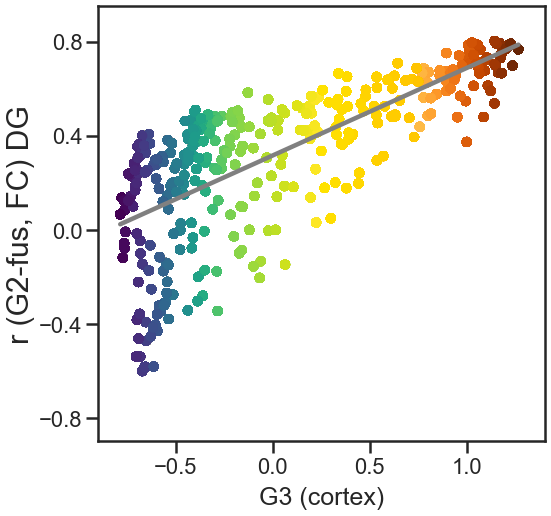

In [18]:
figure = plt.figure(figsize=(8,8), facecolor='w')

ax     = figure.gca()
ax.patch.set_facecolor('white')

xLabel = ax.set_xlabel('\nG3 (cortex)', linespacing=0, fontsize=25)
yLabel = ax.set_ylabel('r (G2-fus, FC) DG', linespacing=3.1, fontsize=30)

sns.regplot(x=XG3_labeled[~np.isnan(r2_LDG_labeled)],
            y=r2_LDG_labeled[~np.isnan(r2_LDG_labeled)], color='gray', scatter=False)

ax.scatter(XG3_labeled[~np.isnan(r2_LDG_labeled)], 
           r2_LDG_labeled[~np.isnan(r2_LDG_labeled)],
           c = XG3_labeled[~np.isnan(r2_LDG_labeled)], 
           cmap= plot_funcs.margu_map(),
           s = 100,
           linewidth = 0,
           marker = 'o', )

ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xlim([-0.9, 1.4])
ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
ax.set_ylim([-0.9, 0.95])

sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_style("ticks")

print("Pearson correlation: ", pearsonr(r2_LDG_labeled[~np.isnan(r2_LDG_labeled)],
                                        XG3_labeled[~np.isnan(r2_LDG_labeled)]))


# spin permutations on correlations 


In [19]:
## test the association between r (G1-fus, FC) and G3 (cortex)

In [20]:
# load the conte69 hemisphere surfaces and spheres
surf_lh, surf_rh = load_conte69()
sphere_lh, sphere_rh = load_conte69(as_sphere=True)

# assign the data to left and right hemispheres
r1_LSUB_labeled_LH = r1_LSUB_labeled[0:32492]
r1_LSUB_labeled_RH = r1_LSUB_labeled[32492:]

r1_LCA_labeled_LH = r1_LCA_labeled[0:32492]
r1_LCA_labeled_RH = r1_LCA_labeled[32492:]

r1_LDG_labeled_LH = r1_LDG_labeled[0:32492]
r1_LDG_labeled_RH = r1_LDG_labeled[32492:]


In [21]:
# Let's create some rotations
n_rand = 1000

sp = SpinPermutations(n_rep=n_rand, random_state=0)
sp.fit(sphere_lh, points_rh=sphere_rh)

r1_LSUB_labeled_rotated = np.hstack(sp.randomize(r1_LSUB_labeled_LH, r1_LSUB_labeled_RH))
r1_LCA_labeled_rotated = np.hstack(sp.randomize(r1_LCA_labeled_LH, r1_LCA_labeled_RH))
r1_LDG_labeled_rotated = np.hstack(sp.randomize(r1_LDG_labeled_LH, r1_LDG_labeled_RH))


R1_lsub_labeled:
 Pearson corr : -6.71587e-01
 Observed p : 0.00000e+00
 Spin p: 0.00000e+00

R1_lca_labeled:
 Pearson corr : 5.64139e-03
 Observed p : 1.69189e-01
 Spin p: 9.67000e-01

R1_ldg_labeled:
 Pearson corr : 5.02177e-01
 Observed p : 0.00000e+00
 Spin p: 0.00000e+00



<Figure size 432x288 with 0 Axes>

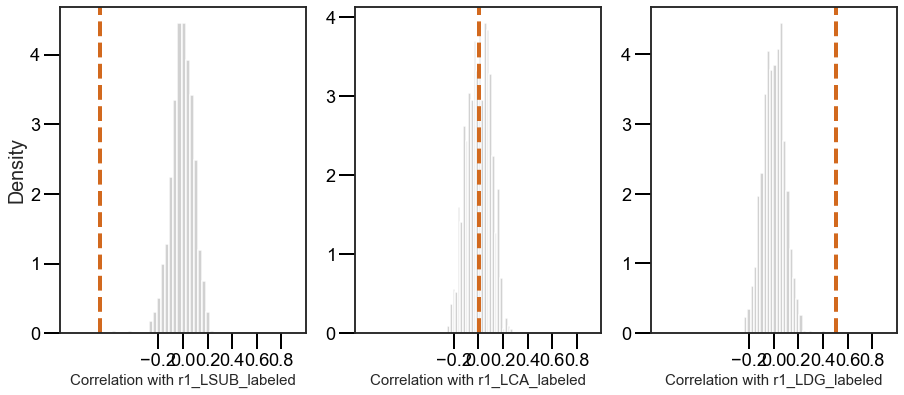

In [22]:
fig = plt.figure()
sns.set_context("talk", font_scale=1.1)
fig, axs = plt.subplots(1, 3, figsize=(15,6))

feats = {'r1_LSUB_labeled': r1_LSUB_labeled,
         'r1_LCA_labeled' : r1_LCA_labeled,
         'r1_LDG_labeled' : r1_LDG_labeled,}

rotated = {'r1_LSUB_labeled': r1_LSUB_labeled_rotated, 
           'r1_LCA_labeled' : r1_LCA_labeled_rotated,
           'r1_LDG_labeled' : r1_LDG_labeled_rotated}

r_spin = np.empty(n_rand)
mask = ~np.isnan(XG3_labeled)


for k, (fn, feat) in enumerate(feats.items()):
    r_obs, pv_obs = pearsonr(feat[mask], XG3_labeled[mask])

    # Compute perm pval
    for i, perm in enumerate(rotated[fn]):
        mask_rot = mask & ~np.isnan(perm)  # Remove midline
        r_spin[i] = pearsonr(perm[mask_rot], XG3_labeled[mask_rot])[0]
    pv_spin = np.mean(np.abs(r_spin) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_spin, bins=25, density=True, alpha=0.9, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=4, ls='--', color='chocolate')
    axs[k].set_xlabel(f'Correlation with {fn}', fontsize=15)
    axs[k].set_xlim([-1, 1])
    axs[k].set_xticks([-0.2, 0 , 0.2, 0.4, 0.6, 0.8])
    axs[k].tick_params(colors = 'k',length=16, width=2)
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n Pearson corr : {r_obs:.5e}\n Observed p : {pv_obs:.5e}\n Spin p: {pv_spin:.5e}\n')



## test the association between r (G2-fus, FC) and G3 (cortex)

In [23]:
# load the conte69 hemisphere surfaces and spheres
surf_lh, surf_rh = load_conte69()
sphere_lh, sphere_rh = load_conte69(as_sphere=True)

# assign the data to left and right hemispheres
r2_LSUB_labeled_LH = r2_LSUB_labeled[0:32492]
r2_LSUB_labeled_RH = r2_LSUB_labeled[32492:]

r2_LCA_labeled_LH = r2_LCA_labeled[0:32492]
r2_LCA_labeled_RH = r2_LCA_labeled[32492:]

r2_LDG_labeled_LH = r2_LDG_labeled[0:32492]
r2_LDG_labeled_RH = r2_LDG_labeled[32492:]


In [24]:
# Let's create some rotations
n_rand = 1000

sp = SpinPermutations(n_rep=n_rand, random_state=0)
sp.fit(sphere_lh, points_rh=sphere_rh)

r2_LSUB_labeled_rotated = np.hstack(sp.randomize(r2_LSUB_labeled_LH, r2_LSUB_labeled_RH))
r2_LCA_labeled_rotated = np.hstack(sp.randomize(r2_LCA_labeled_LH, r2_LCA_labeled_RH))
r2_LDG_labeled_rotated = np.hstack(sp.randomize(r2_LDG_labeled_LH, r2_LDG_labeled_RH))


R2_lsub_labeled:
 Pearson corr : 8.17871e-01
 Observed p : 0.00000e+00
 Spin p: 0.00000e+00

R2_lca_labeled:
 Pearson corr : 7.91761e-01
 Observed p : 0.00000e+00
 Spin p: 0.00000e+00

R2_ldg_labeled:
 Pearson corr : 7.28307e-01
 Observed p : 0.00000e+00
 Spin p: 0.00000e+00



<Figure size 432x288 with 0 Axes>

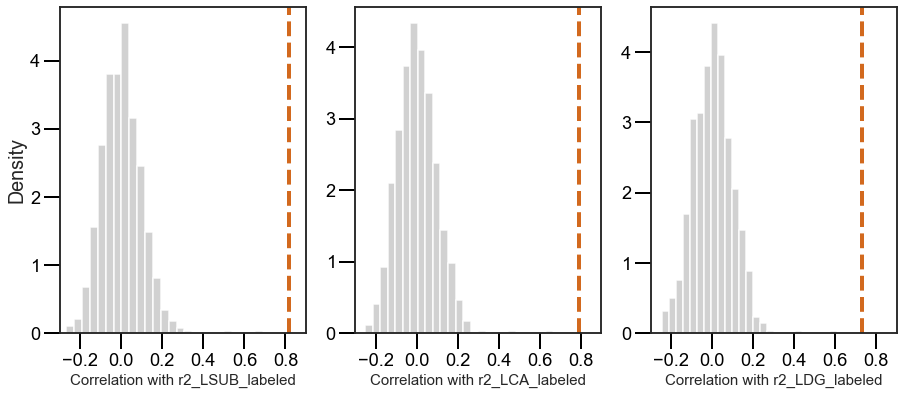

In [25]:
fig = plt.figure()
sns.set_context("talk", font_scale=1.1)
fig, axs = plt.subplots(1, 3, figsize=(15,6))

feats = {'r2_LSUB_labeled': r2_LSUB_labeled,
         'r2_LCA_labeled' : r2_LCA_labeled,
         'r2_LDG_labeled' : r2_LDG_labeled,}

rotated = {'r2_LSUB_labeled': r2_LSUB_labeled_rotated, 
           'r2_LCA_labeled' : r2_LCA_labeled_rotated,
           'r2_LDG_labeled' : r2_LDG_labeled_rotated}

r_spin = np.empty(n_rand)
mask = ~np.isnan(XG3_labeled)


for k, (fn, feat) in enumerate(feats.items()):
    r_obs, pv_obs = pearsonr(feat[mask], XG3_labeled[mask])

    # Compute perm pval
    for i, perm in enumerate(rotated[fn]):
        mask_rot = mask & ~np.isnan(perm)  # Remove midline
        r_spin[i] = pearsonr(perm[mask_rot], XG3_labeled[mask_rot])[0]
    pv_spin = np.mean(np.abs(r_spin) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_spin, bins=25, density=True, alpha=0.9, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=4, ls='--', color='chocolate')
    axs[k].set_xlabel(f'Correlation with {fn}', fontsize=15)
    axs[k].set_xlim([-0.3, 0.9])
    axs[k].set_xticks([-0.2, 0 , 0.2, 0.4, 0.6, 0.8])
    axs[k].tick_params(colors = 'k',length=16, width=2)
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n Pearson corr : {r_obs:.5e}\n Observed p : {pv_obs:.5e}\n Spin p: {pv_spin:.5e}\n')

